In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

In [2]:
batch_size = 512

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root="../../../datasets", train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root="../../../datasets", train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, **kwargs):
        super(Autoencoder, self).__init__()
        
        self.input_shape = kwargs["input_shape"]
        self.output_shape = kwargs["output_shape"]
        self.hidden_layer_sizes = kwargs["hidden_layer_sizes"]
        self.n_dims_code = kwargs["n_dims_code"]
        self.activation_fn = kwargs["activation_fn"]
        
        # encoder
        encoder_layers = []
        encoder_layers.append(nn.Linear(in_features=self.input_shape, out_features=self.hidden_layer_sizes[0]))
        encoder_layers.append(self.activation_fn(inplace=True))
        for i in range(1, len(self.hidden_layer_sizes)):
            encoder_layers.append(nn.Linear(in_features=self.hidden_layer_sizes[i-1], out_features=self.hidden_layer_sizes[i]))
            encoder_layers.append(self.activation_fn(inplace=True))
        self.encoder = nn.Sequential(*encoder_layers)
        self.fc_mu = nn.Linear(self.hidden_layer_sizes[-1], self.n_dims_code)
        self.fc_var = nn.Linear(self.hidden_layer_sizes[-1], self.n_dims_code)

        # decoder
        decoder_layers = []
        decoder_layers.append(nn.Linear(in_features=self.n_dims_code, out_features=self.hidden_layer_sizes[-1]))
        decoder_layers.append(self.activation_fn(inplace=True))
        for i in range(len(self.hidden_layer_sizes)-1, 0, -1):
            decoder_layers.append(nn.Linear(in_features=self.hidden_layer_sizes[i], out_features=self.hidden_layer_sizes[i-1]))
            decoder_layers.append(self.activation_fn(inplace=True))
        decoder_layers.append(nn.Linear(in_features=self.hidden_layer_sizes[i-1], out_features=self.output_shape))
        # decoder_layers.append(self.activation_fn(inplace=True))
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)
        
    def forward(self, x):
                    
        z, mu, log_var = self.generate_code(x)
        x = self.decoder(z)
            
        return x, mu, log_var
    
    def generate_code(self, x):
        
        result = self.encoder(x)
        
        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        
        # The reparameterization trick
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = eps * std + mu
                
        return z, mu, log_var


In [5]:
input_shape = 784
output_shape = 784
HIDDEN_LAYER_UNITS = [512, 384, 256]  # [256, 128, 64], [512, 384, 256]
n_dims_code = 256
ACTIVATION_FUNCTION = nn.ReLU

learning_rate = 1e-3

In [6]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = Autoencoder(input_shape=input_shape,
                    output_shape=output_shape,
                    hidden_layer_sizes=HIDDEN_LAYER_UNITS,
                    n_dims_code=n_dims_code,
                    activation_fn=ACTIVATION_FUNCTION)
model = model.to(device)
print("model: ", model)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print("optimizer: ", optimizer)

# mean-squared error loss
# criterion = nn.MSELoss()
criterion = nn.BCELoss().to(device)
print("criterion: ", criterion)

device:  cuda
model:  Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=384, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=384, out_features=256, bias=True)
    (5): ReLU(inplace=True)
  )
  (fc_mu): Linear(in_features=256, out_features=256, bias=True)
  (fc_var): Linear(in_features=256, out_features=256, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=384, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=384, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Sigmoid()
  )
)
optimizer:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
criterion:  BCELoss()


In [7]:
beta = 0 # Good
# beta = 0.001 # Good
# beta = 0.01 # Good
# beta = 1 # Bad
# beta = 100 # Bad

epochs = 20  # 20

cost_log = []
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        
        batch_features = batch_features.view(-1, 784).to(device)  # [512, 1, 28, 28] to [512, 784]
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs, mu, log_var = model(batch_features)
        
        # compute training reconstruction loss
        recons_loss = criterion(outputs, batch_features)
        
        # Kullback Leibler divergence: measure the difference between two distributions
        # Here we measure the divergence between the latent distribution and N(0, 1)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
        
        # https://openreview.net/forum?id=Sy2fzU9gl
        train_loss = recons_loss + beta * kld_loss
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    cost_log.append(loss)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/20, recon loss = 0.27686620
epoch : 2/20, recon loss = 0.21655159
epoch : 3/20, recon loss = 0.17147649
epoch : 4/20, recon loss = 0.15226402
epoch : 5/20, recon loss = 0.14170798
epoch : 6/20, recon loss = 0.13202865
epoch : 7/20, recon loss = 0.12555885
epoch : 8/20, recon loss = 0.11978565
epoch : 9/20, recon loss = 0.11463023
epoch : 10/20, recon loss = 0.11006776
epoch : 11/20, recon loss = 0.10695718
epoch : 12/20, recon loss = 0.10450595
epoch : 13/20, recon loss = 0.10222439
epoch : 14/20, recon loss = 0.10029578
epoch : 15/20, recon loss = 0.09870924
epoch : 16/20, recon loss = 0.09736202
epoch : 17/20, recon loss = 0.09620121
epoch : 18/20, recon loss = 0.09492658
epoch : 19/20, recon loss = 0.09373068
epoch : 20/20, recon loss = 0.09273967


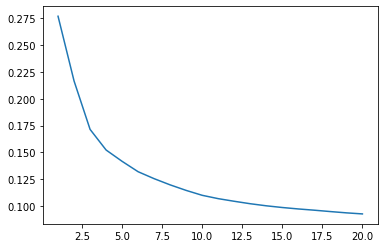

In [8]:
plt.plot(range(1, len(cost_log)+1), cost_log)
plt.show()

In [9]:
with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, 784).to(device)
        reconstruction, mu, log_var = model(test_examples)
        break

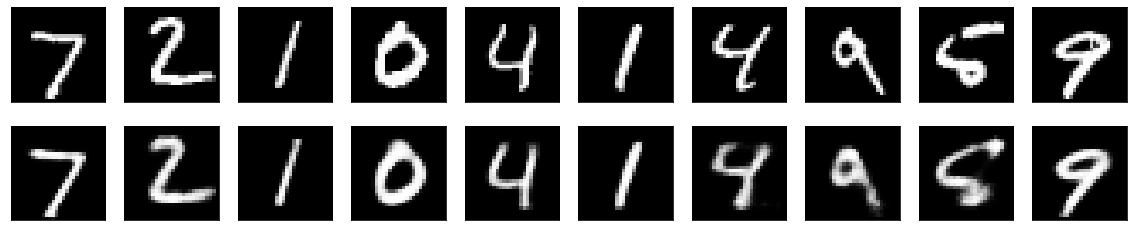

In [10]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

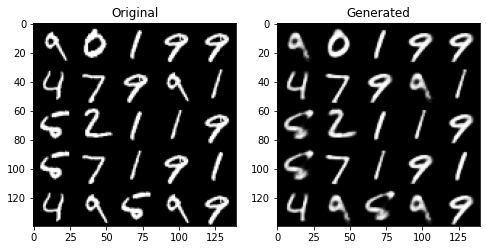

In [11]:
# Testing
# Encode and decode images from test set and visualize their reconstruction.
n = 5
examples = np.random.randint(len(reconstruction), size=n*n)
# examples = np.arange(len(reconstruction))

canvas_orig = np.empty((28 * n, 28 * n))
canvas_recon = np.empty((28 * n, 28 * n))
fig, all_plots = plt.subplots(1, 2, figsize=(8, 8))
for i in range(n):        
    # Display original images
    for j, example in zip(range(n), examples[i*n:i*n+n]):
        # Draw the generated digits
        a = test_examples[example].cpu().reshape([28, 28])
        canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = test_examples[example].cpu().reshape([28, 28])
    # Display reconstructed images
    for j, example in zip(range(n), examples[i*n:i*n+n]):
        # Draw the generated digits
        canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = reconstruction[example].cpu().reshape([28, 28])

all_plots[0].set_title("Original")
all_plots[0].imshow(canvas_orig, origin="upper", cmap="gray")

all_plots[1].set_title("Generated")
all_plots[1].imshow(canvas_recon, origin="upper", cmap="gray")
plt.show()

In [12]:
with torch.no_grad():
    code = []
    labels = []
    for batch_features, label in test_loader:
        test_examples = batch_features.view(-1, 784).to(device)
        z, mu, log_var = model.generate_code(test_examples)
        code.append(z.cpu().numpy())
        labels.append(label.numpy())
    
#     test_examples = test_dataset.data
#     labels = test_dataset.targets.numpy()
#     code, mu, log_var = model.generate_code(test_examples.view(-1, 784).to(device).float())
#     code = code.cpu().numpy()
    
    code = np.array(code).reshape(-1, n_dims_code)
    labels = np.array(labels)

In [13]:
print("code.shape: ", code.shape)
print("labels.shape: ", labels.shape)

code.shape:  (10000, 256)
labels.shape:  (1000, 10)


In [14]:
code = PCA(n_components=2).fit_transform(code)

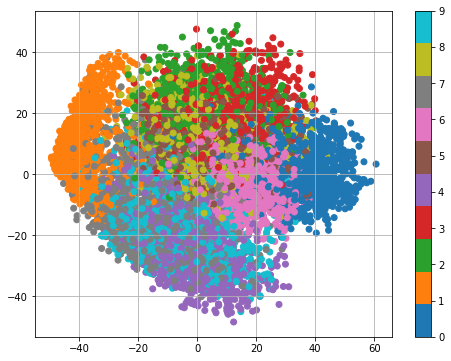

In [15]:
plt.figure(figsize=(8, 6)) 
plt.scatter(code[:, 0], code[:, 1], c=labels, cmap='tab10')
plt.colorbar()
plt.grid()